In [1]:
import pandas as pd
import numpy as np
import glob
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

root_dir = '/oak/stanford/groups/horence/rob/isoform_localizations/'

sys.path.append(os.path.join(root_dir,'scripts'))
import spatial_utils
import plot_utils

# Combine the periphery rank scores with the cluster ids

In [2]:
df = pd.read_csv('../processed_data/rank_periph.csv')
df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208


In [3]:
cell_clusters = pd.read_csv('../processed_data/20210122_cell_id_to_cluster_number.csv')
cell_clusters.head()

,cell_id,cluster
0,10000143038275111136124942858811168393,3
1,100001798412490480358118871918100400402,5
2,100006878605830627922364612565348097824,26
3,100007228202835962319771548915451072492,15
4,100009332472089331948140672873134747603,2


In [5]:
df['cluster_id'] = df['cell_id'].map(
    dict(cell_clusters[['cell_id','cluster']].values)
)

df.head()

,cell_id,target_molecule_name,num_cell_spots,num_gene_spots,metric_name,raw_metric,cluster_id
0,100024126192764500990464846159908804485,1700022I11Rik,841,1,periphery_ranks,0.048751,9
1,100024126192764500990464846159908804485,Acta2,841,4,periphery_ranks,0.894768,9
2,100024126192764500990464846159908804485,Adam2,841,1,periphery_ranks,0.752675,9
3,100024126192764500990464846159908804485,Adamts4,841,1,periphery_ranks,0.859691,9
4,100024126192764500990464846159908804485,Adra1b,841,26,periphery_ranks,0.325208,9


In [6]:
df['cluster_id'].isnull().any()

False

In [8]:
df['cluster_id'].unique().size

32

# Summarizing periphery ranks over all cells

Going to take different quantiles of the raw_metric per gene over all cells

However, going to ignore a gene/cell value if the num_gene_spots is less than 10 before doing the aggregation

Want to keep the information of what cluster_ids were present

In [56]:
import itertools

variables = {
    'quantile': [0.25, 0.5, 0.75],
    'threshold': [0,5,10],
    'cluster_id': [-1]+df['cluster_id'].unique() #-1 means any cluster    
}

summary_df = pd.DataFrame()

for vs in itertools.product(*variables.values()):
    named_vs = {k:v for k,v in zip(variables.keys(),vs)}
    
    #Dont filter on cluster ids if -1 is passed in
    filters = df['num_gene_spots'].ge(named_vs['threshold'])
    if named_vs['cluster_id'] != -1:
        filters = filters & df['cluster_id'].eq(named_vs['cluster_id'])
    
    sub_summary_df = (
        df[filters]
        .groupby('target_molecule_name')
        ['raw_metric']
        .agg(
            number_of_cells = 'count',
            summary_metric = lambda x: np.quantile(x,named_vs['quantile'])
        )
        .reset_index()
    )

    for k,v in named_vs.items():
        sub_summary_df[k] = v
        
    summary_df = pd.concat((summary_df, sub_summary_df))
    
print(summary_df.shape)
summary_df.head()

(44373, 6)


,target_molecule_name,number_of_cells,summary_metric,quantile,threshold,cluster_id
0,1700022I11Rik,1,0.885043,0.25,0,8
1,1810046K07Rik,3,0.410499,0.25,0,8
2,Acta2,9,0.157895,0.25,0,8
3,Adam2,1,0.134309,0.25,0,8
4,Adamts2,13,0.539788,0.25,0,8


In [57]:
summary_df[
    summary_df['target_molecule_name'].eq('Ctss') &
    summary_df['cluster_id'].eq(-1)
].sort_values('summary_metric').reset_index(drop=True)

,target_molecule_name,number_of_cells,summary_metric,quantile,threshold,cluster_id
0,Ctss,1241,0.127644,0.25,5,-1
1,Ctss,542,0.150840,0.25,10,-1
2,Ctss,12004,0.158537,0.25,0,-1
3,Ctss,1241,0.234354,0.50,5,-1
4,Ctss,542,0.242999,0.50,10,-1
5,Ctss,542,0.378118,0.75,10,-1
6,Ctss,12004,0.388772,0.50,0,-1
7,Ctss,1241,0.393655,0.75,5,-1
8,Ctss,12004,0.662467,0.75,0,-1


In [68]:
summary_df[
    summary_df['target_molecule_name'].eq('Ctss') &
    summary_df['number_of_cells'].ge(10) &
    summary_df['threshold'].ge(10) &
    summary_df['quantile'].eq(0.75)
]

,target_molecule_name,number_of_cells,summary_metric,quantile,threshold,cluster_id
40,Ctss,62,0.382808,0.75,10,4
20,Ctss,14,0.527297,0.75,10,11
29,Ctss,13,0.620724,0.75,10,29
31,Ctss,30,0.278165,0.75,10,0
55,Ctss,542,0.378118,0.75,10,-1
36,Ctss,57,0.330477,0.75,10,6
37,Ctss,24,0.321298,0.75,10,21
33,Ctss,42,0.425816,0.75,10,9
35,Ctss,13,0.178311,0.75,10,23
32,Ctss,11,0.544851,0.75,10,30


# Plotting hits of interest

In [69]:
spots = pd.read_csv('../processed_data/q90_rna_spots.csv')
cells = pd.read_csv('../processed_data/q90_cells.csv')

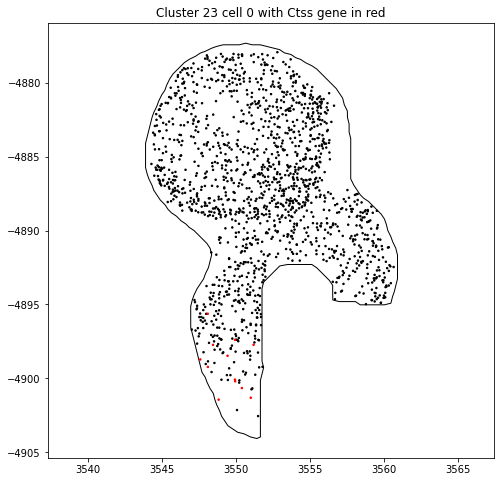

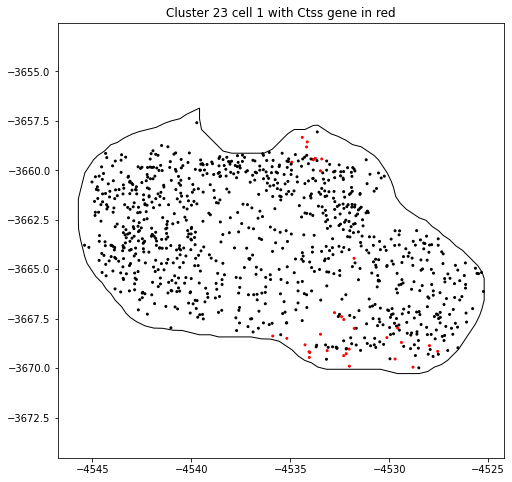

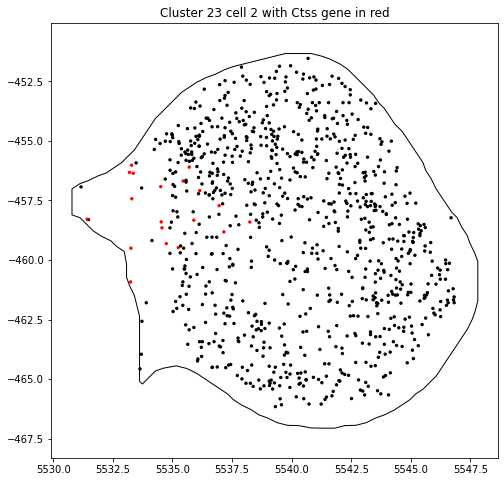

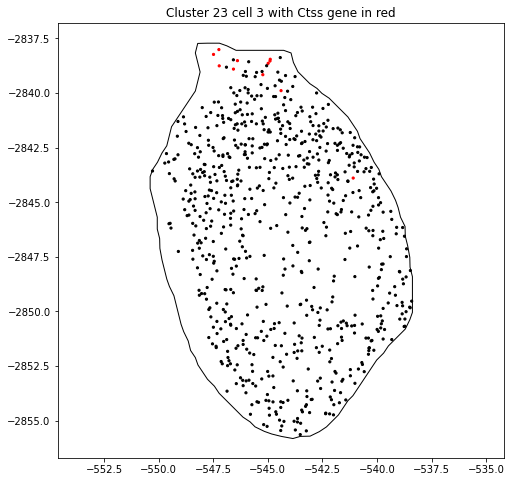

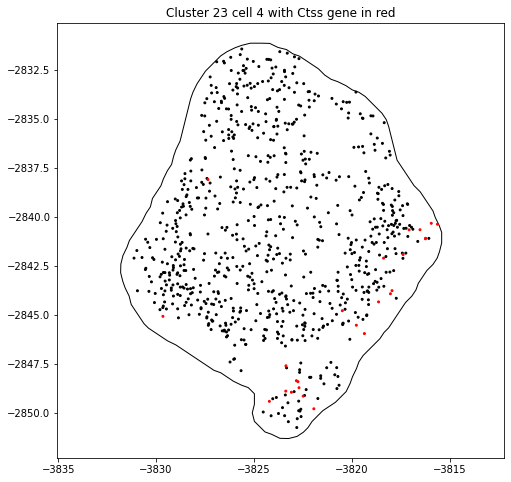

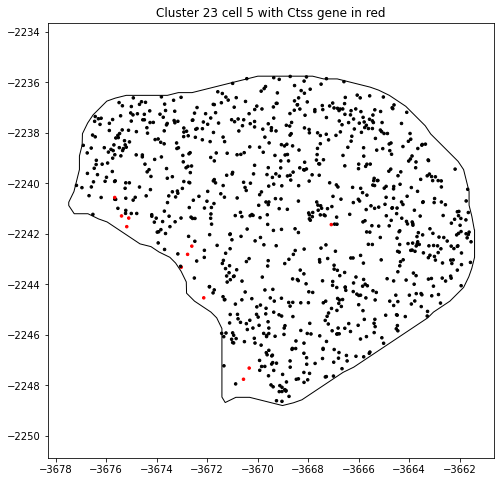

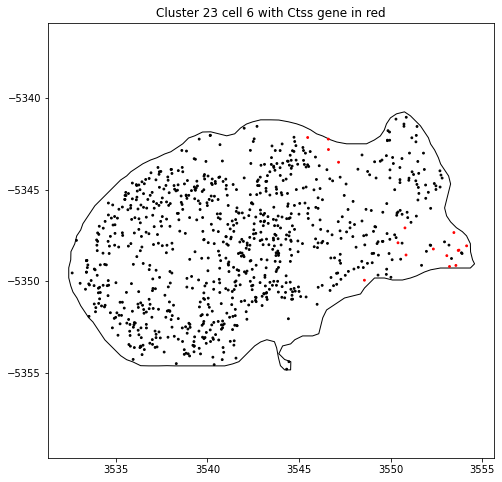

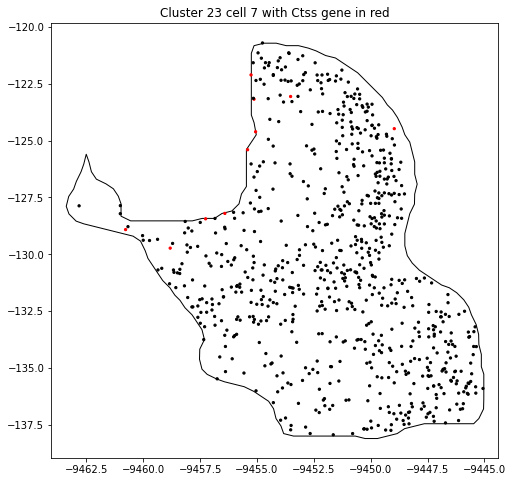

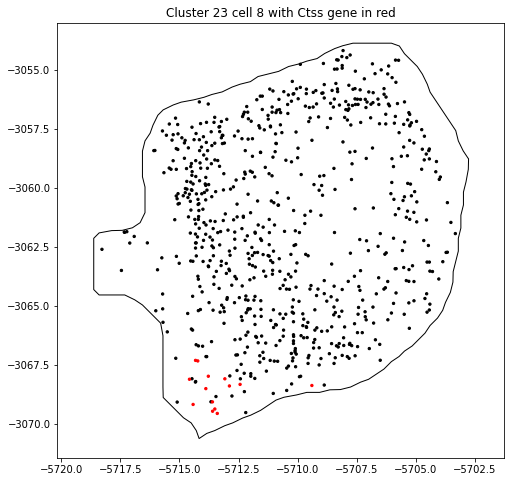

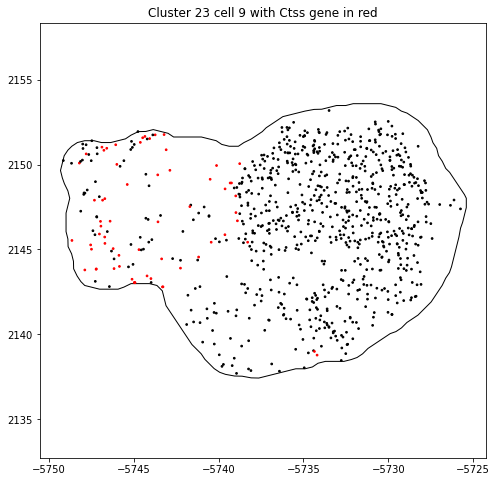

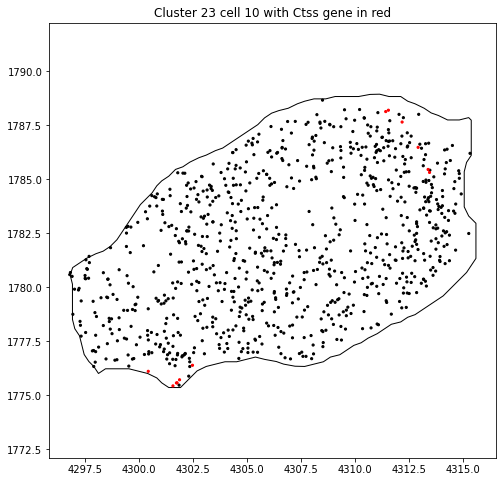

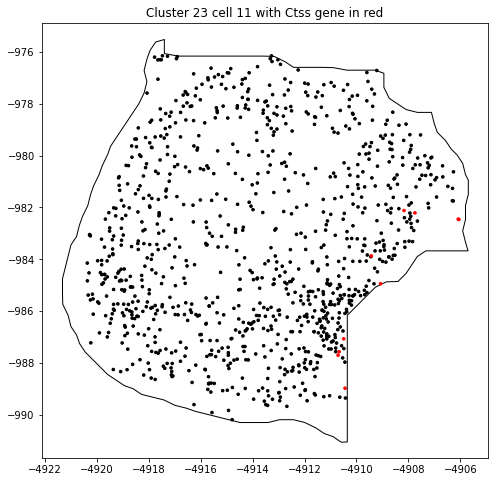

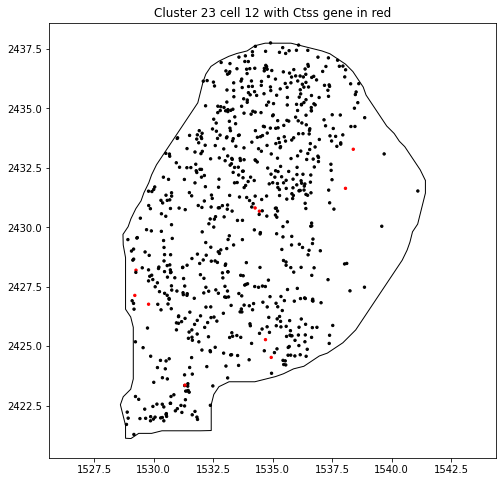

In [75]:
low_rank_clust_cell_ids = df[
    df['target_molecule_name'].eq('Ctss') &
    df['num_gene_spots'].ge(10) &
    df['cluster_id'].eq(23)
]['cell_id']

import importlib
importlib.reload(plot_utils)

sub_spots = spots[spots['cell_id'].isin(low_rank_clust_cell_ids)]
sub_cells = cells[cells['cell_id'].isin(low_rank_clust_cell_ids)]

plots = plot_utils.plot_spot_cells(
    spots = sub_spots, 
    cells = sub_cells,
    spot_colors={'Ctss':'r'},
)

for i,(fig,ax) in enumerate(plots):
    plt.title('Cluster 23 cell {} with Ctss gene in red'.format(i))
    plt.show()
    plt.close()

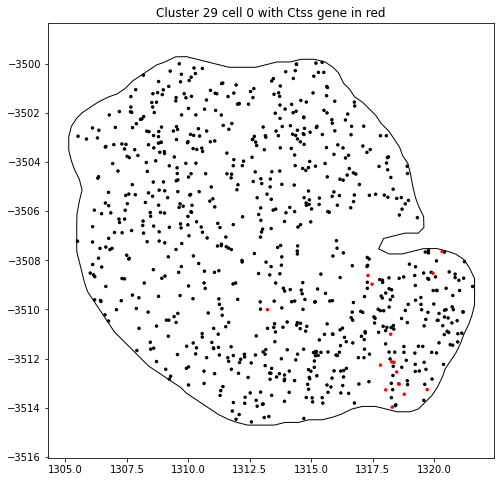

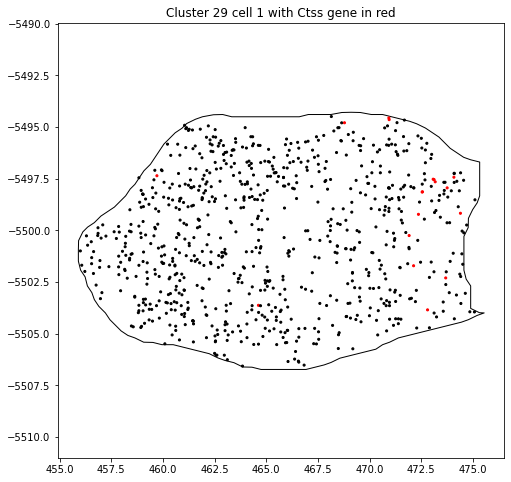

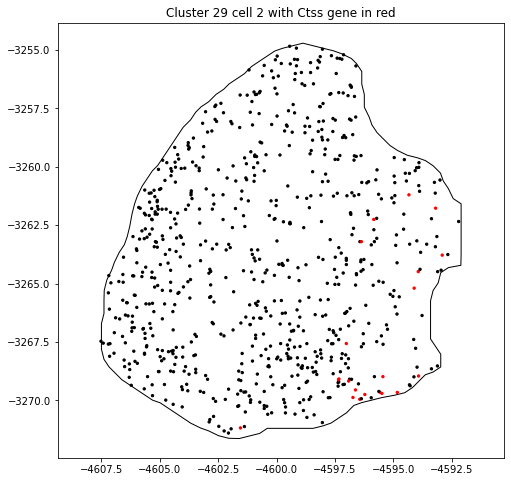

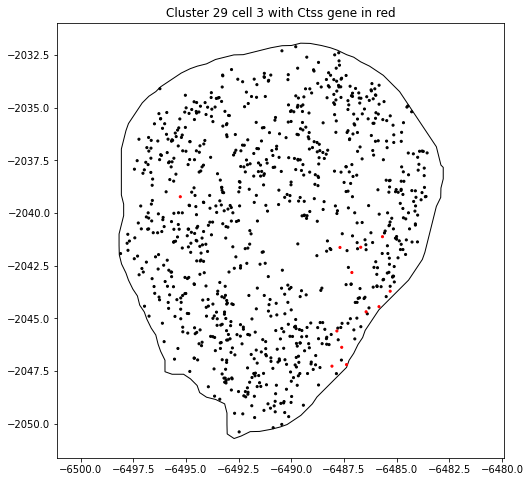

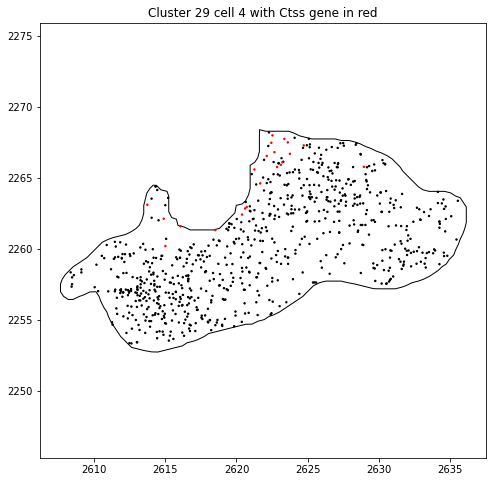

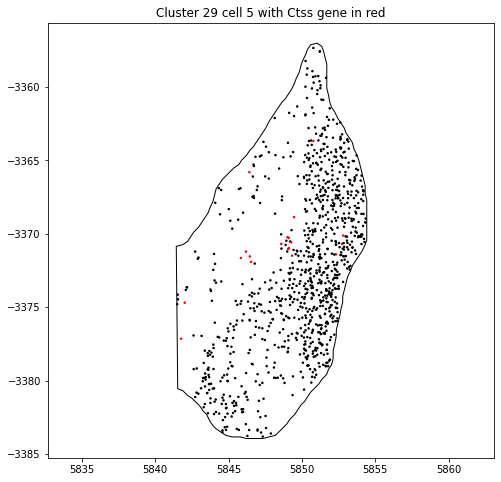

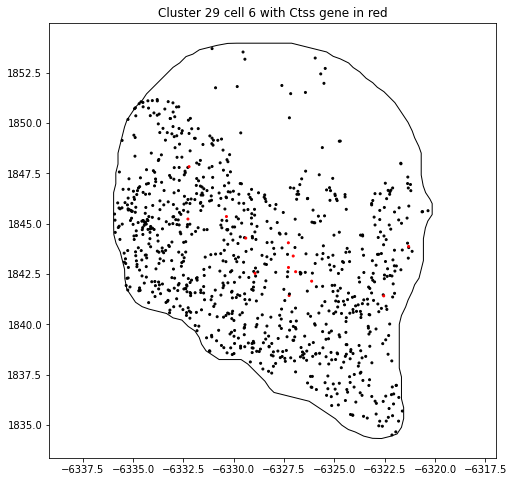

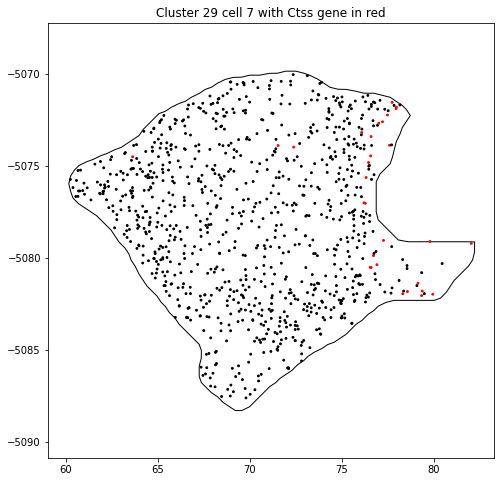

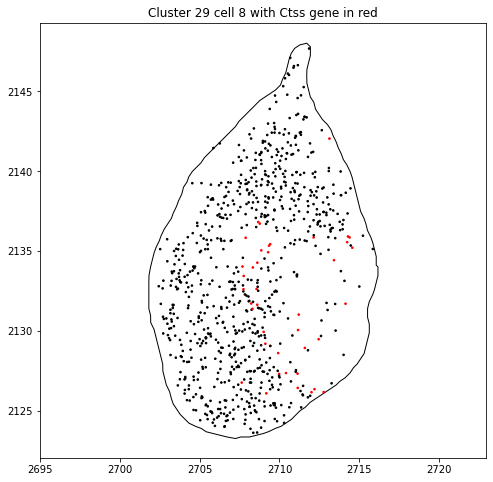

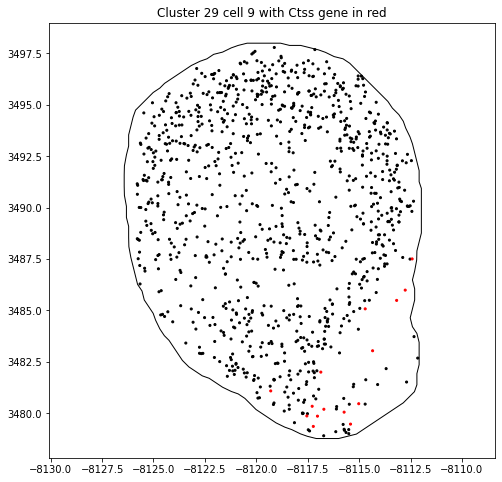

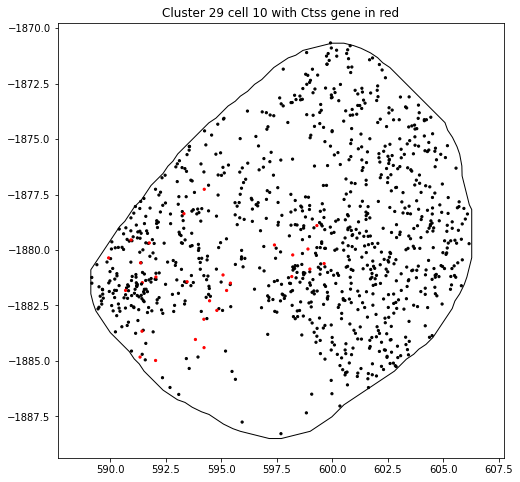

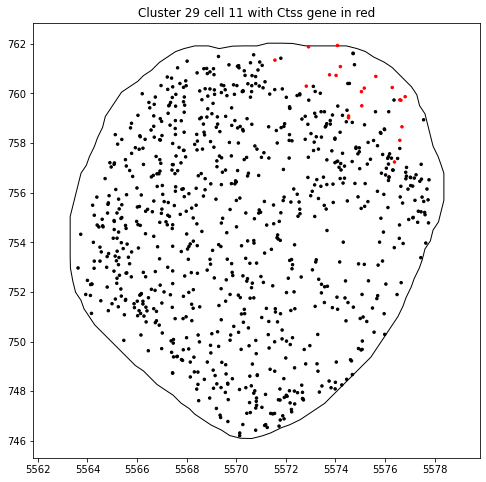

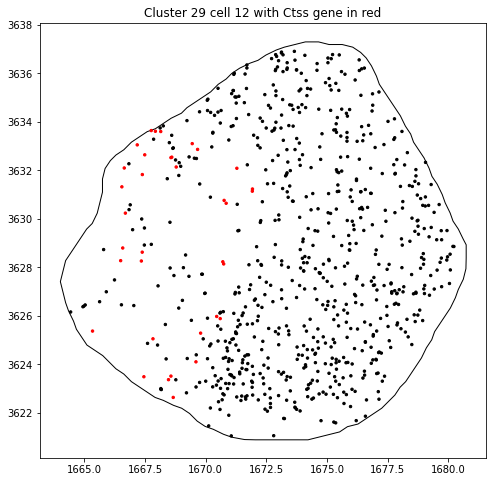

In [77]:
high_rank_clust_cell_ids = df[
    df['target_molecule_name'].eq('Ctss') &
    df['num_gene_spots'].ge(10) &
    df['cluster_id'].eq(29)
]['cell_id']

import importlib
importlib.reload(plot_utils)

sub_spots = spots[spots['cell_id'].isin(high_rank_clust_cell_ids)]
sub_cells = cells[cells['cell_id'].isin(high_rank_clust_cell_ids)]

plots = plot_utils.plot_spot_cells(
    spots = sub_spots, 
    cells = sub_cells,
    spot_colors={'Ctss':'r'},
)

for i,(fig,ax) in enumerate(plots):
    plt.title('Cluster 29 cell {} with Ctss gene in red'.format(i))
    plt.show()
    plt.close()

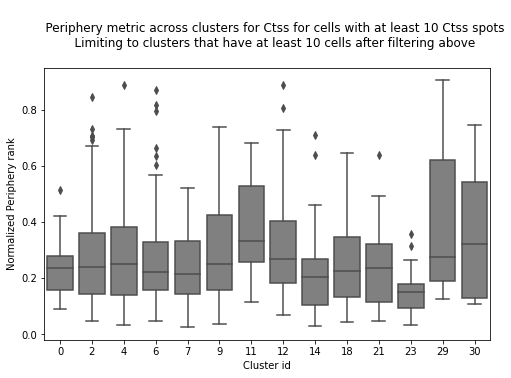

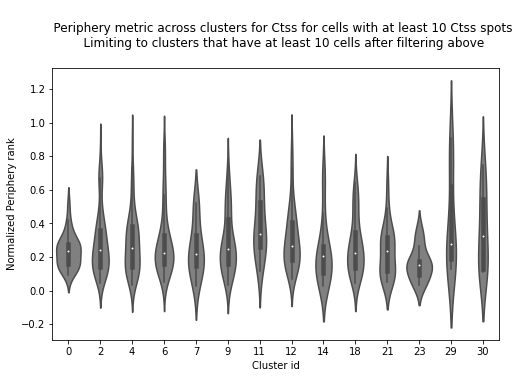

In [101]:
plot_df = df[
    df['target_molecule_name'].eq('Ctss') &
    df['num_gene_spots'].ge(10)
]

plot_df['num_cells'] = plot_df['cluster_id'].map(plot_df.groupby('cluster_id').size())

plot_df = plot_df[plot_df['num_cells'].ge(10)]

fig = plt.figure(figsize=(8,5))
sns.boxplot(
    x = 'cluster_id',
    y = 'raw_metric',
    color = 'grey',
    data = plot_df,
)
plt.title(
    """
    Periphery metric across clusters for Ctss for cells with at least 10 Ctss spots
    Limiting to clusters that have at least 10 cells after filtering above
    """
)
plt.ylabel('Normalized Periphery rank')
plt.xlabel('Cluster id')
plt.show()
plt.close()


fig = plt.figure(figsize=(8,5))
sns.violinplot(
    x = 'cluster_id',
    y = 'raw_metric',
    color = 'grey',
    data = plot_df,
)
plt.title(
    """
    Periphery metric across clusters for Ctss for cells with at least 10 Ctss spots
    Limiting to clusters that have at least 10 cells after filtering above
    """
)
plt.xlabel('Cluster id')
plt.ylabel('Normalized Periphery rank')
plt.show()
plt.close()

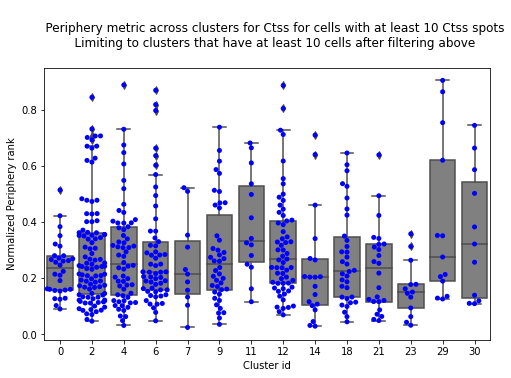

In [103]:
fig = plt.figure(figsize=(8,5))

sns.boxplot(
    x = 'cluster_id',
    y = 'raw_metric',
    color = 'grey',
    data = plot_df,
)

sns.swarmplot(
    x = 'cluster_id',
    y = 'raw_metric',
    color = 'blue',
    data = plot_df,
)

plt.title(
    """
    Periphery metric across clusters for Ctss for cells with at least 10 Ctss spots
    Limiting to clusters that have at least 10 cells after filtering above
    """
)
plt.xlabel('Cluster id')
plt.ylabel('Normalized Periphery rank')
plt.show()
plt.close()

,cell_id,raw_metric
1660593,287400305855922254436533645004389615741,0.905528
1680868,289416032152307293617986248960493842281,0.864750
1923090,316887497559394814888577141371460079916,0.754601
2141718,35455225056682768586571186190289032521,0.620724


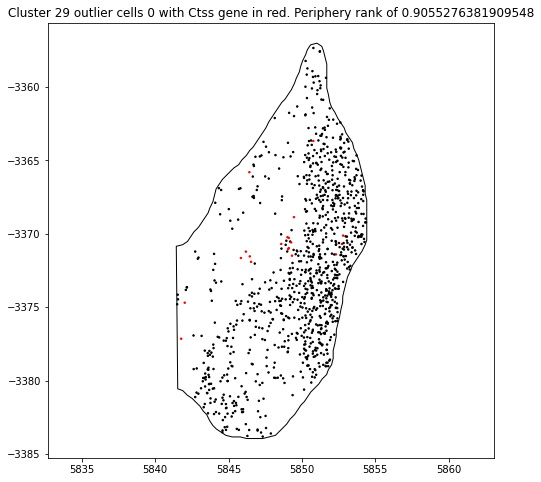

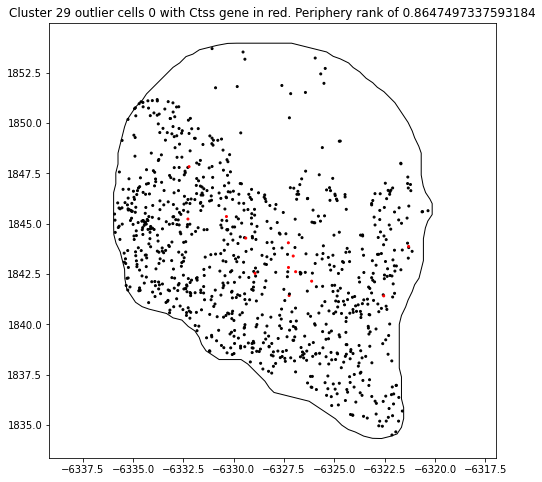

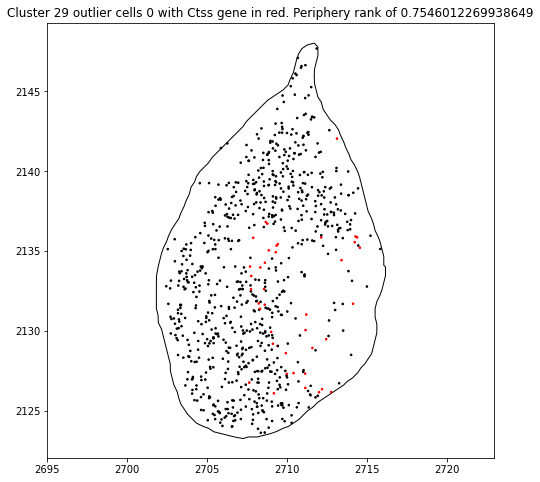

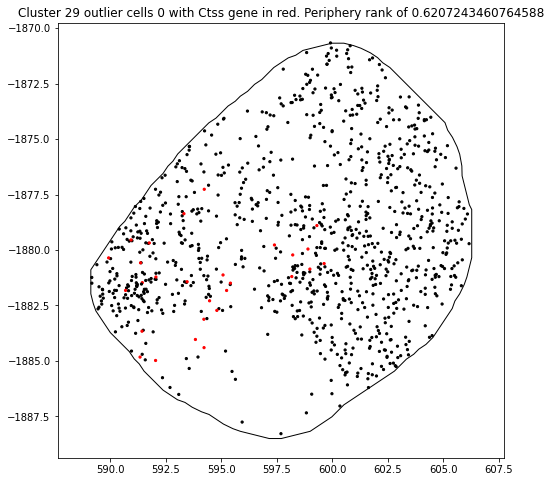

In [110]:
x = (
    df[
        df['target_molecule_name'].eq('Ctss') &
        df['num_gene_spots'].ge(10) &
        df['cluster_id'].eq(29)
    ]
    .sort_values('raw_metric',ascending=False)
    .head(4)
    [['cell_id','raw_metric']]
)

import importlib
importlib.reload(plot_utils)

for i,r in x.iterrows():
    
    sub_spots = spots[spots['cell_id'].eq(r['cell_id'])]
    sub_cells = cells[cells['cell_id'].eq(r['cell_id'])]

    plots = plot_utils.plot_spot_cells(
        spots = sub_spots, 
        cells = sub_cells,
        spot_colors={'Ctss':'r'},
    )

    for i,(fig,ax) in enumerate(plots):
        plt.title('Cluster 29 outlier cells {} with Ctss gene in red. Periphery rank of {}'.format(i,r['raw_metric']))
        plt.show()
        plt.close()

# Making changes to summary df suggested by Julia

Pivot out the quantiles as columns and make the overall_cluster (cluster_id=-1) values as columns too

In [147]:
summary_df.head()

,target_molecule_name,number_of_cells,summary_metric,quantile,threshold,cluster_id
0,1700022I11Rik,1,0.885043,0.25,0,8
1,1810046K07Rik,3,0.410499,0.25,0,8
2,Acta2,9,0.157895,0.25,0,8
3,Adam2,1,0.134309,0.25,0,8
4,Adamts2,13,0.539788,0.25,0,8


In [186]:
qpiv_summary_df.head()

quantile,target_molecule_name,number_of_cells,threshold,cluster_id,cluster_Q25,cluster_Q50,cluster_Q75
0,1700022I11Rik,1,0,3,0.990716,0.990716,0.990716
1,1700022I11Rik,1,0,8,0.885043,0.885043,0.885043
2,1700022I11Rik,3,0,32,0.479827,0.625874,0.797600
3,1700022I11Rik,4,0,10,0.094930,0.258174,0.439285
4,1700022I11Rik,4,0,11,0.651320,0.716051,0.815830


In [189]:

qpiv_summary_df = summary_df.pivot_table(
    index = [
        'target_molecule_name',
        'number_of_cells',
        'threshold',
        'cluster_id',
    ],
    columns='quantile',
    values='summary_metric',
).reset_index().rename(columns={
    0.25:'cluster_Q25',
    0.50:'cluster_Q50',
    0.75:'cluster_Q75'
})

qpiv_summary_df.columns.name = None #I'm doing something weird and need to drop the columns.name

overall_metric_lookup = (
    qpiv_summary_df[
        qpiv_summary_df['cluster_id'].eq(-1)
    ].groupby([
        'target_molecule_name',
        'threshold',
    ])
    [['cluster_Q25','cluster_Q50','cluster_Q75']].median()
)

qpiv_overall = qpiv_summary_df[qpiv_summary_df['cluster_id'].ne(-1)]
qpiv_overall = qpiv_overall.set_index(['target_molecule_name','threshold'])
qpiv_overall['overall_Q25'] = overall_metric_lookup['cluster_Q25']
qpiv_overall['overall_Q50'] = overall_metric_lookup['cluster_Q50']
qpiv_overall['overall_Q75'] = overall_metric_lookup['cluster_Q75']

qpiv_overall = qpiv_overall.reset_index()
qpiv_overall.head()

,target_molecule_name,threshold,number_of_cells,cluster_id,cluster_Q25,cluster_Q50,cluster_Q75,overall_Q25,overall_Q50,overall_Q75
0,1700022I11Rik,0,1,3,0.990716,0.990716,0.990716,0.316947,0.613456,0.833716
1,1700022I11Rik,0,1,8,0.885043,0.885043,0.885043,0.316947,0.613456,0.833716
2,1700022I11Rik,0,3,32,0.479827,0.625874,0.797600,0.316947,0.613456,0.833716
3,1700022I11Rik,0,4,10,0.094930,0.258174,0.439285,0.316947,0.613456,0.833716
4,1700022I11Rik,0,4,11,0.651320,0.716051,0.815830,0.316947,0.613456,0.833716


In [190]:
qpiv_overall.shape

(14083, 10)

In [199]:
long_df = summary_df[
    summary_df['target_molecule_name'].eq('Ctss') &
    summary_df['number_of_cells'].ge(10) &
    summary_df['threshold'].ge(10) &
    summary_df['quantile'].eq(0.75)
]
print(long_df.shape)
long_df

(13, 6)


,target_molecule_name,number_of_cells,summary_metric,quantile,threshold,cluster_id
40,Ctss,62,0.382808,0.75,10,4
20,Ctss,14,0.527297,0.75,10,11
29,Ctss,13,0.620724,0.75,10,29
31,Ctss,30,0.278165,0.75,10,0
55,Ctss,542,0.378118,0.75,10,-1
36,Ctss,57,0.330477,0.75,10,6
37,Ctss,24,0.321298,0.75,10,21
33,Ctss,42,0.425816,0.75,10,9
35,Ctss,13,0.178311,0.75,10,23
32,Ctss,11,0.544851,0.75,10,30


In [195]:
qp_ctss_df = qpiv_overall[
    qpiv_overall['target_molecule_name'].eq('Ctss') &
    qpiv_overall['number_of_cells'].ge(10) &
    qpiv_overall['threshold'].ge(10)
]
print(qp_ctss_df.shape)
qp_ctss_df

(12, 10)


,target_molecule_name,threshold,number_of_cells,cluster_id,cluster_Q25,cluster_Q50,cluster_Q75,overall_Q25,overall_Q50,overall_Q75
3674,Ctss,10,11,7,0.145149,0.214834,0.332277,0.15084,0.242999,0.378118
3675,Ctss,10,11,30,0.129555,0.322144,0.544851,0.15084,0.242999,0.378118
3681,Ctss,10,13,23,0.094178,0.150943,0.178311,0.15084,0.242999,0.378118
3682,Ctss,10,13,29,0.189798,0.275754,0.620724,0.15084,0.242999,0.378118
3683,Ctss,10,14,11,0.257812,0.334098,0.527297,0.15084,0.242999,0.378118
3690,Ctss,10,24,21,0.116848,0.235729,0.321298,0.15084,0.242999,0.378118
3693,Ctss,10,30,0,0.158583,0.235762,0.278165,0.15084,0.242999,0.378118
3694,Ctss,10,34,18,0.132801,0.226179,0.346570,0.15084,0.242999,0.378118
3697,Ctss,10,42,9,0.159867,0.249543,0.425816,0.15084,0.242999,0.378118
3699,Ctss,10,57,6,0.158625,0.221881,0.330477,0.15084,0.242999,0.378118


In [200]:
qpiv_overall.to_csv('../processed_data/20210122_periph_rank_summary_wide.csv',index=False)
summary_df.to_csv('../processed_data/20210122_periph_rank_summary_long.csv',index=False)

# Identification of bimodal distributions of metrics

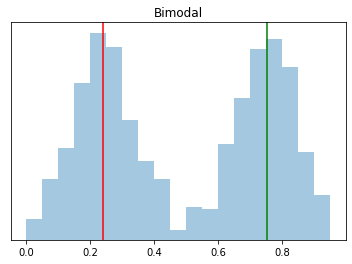

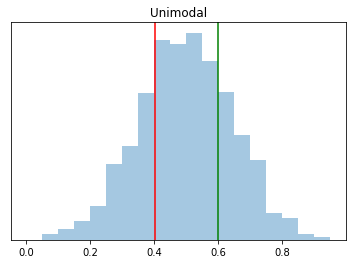

In [146]:
num = 1000

bimodal = np.concatenate((
    np.random.normal(0.25,0.1,int(num/2)),
    np.random.normal(0.75,0.1,int(num/2)),
))
fig = plt.figure()
sns.distplot(bimodal,kde=False,bins=np.arange(0,1,0.05))
plt.axvline(np.quantile(bimodal,0.25),color='r')
plt.axvline(np.quantile(bimodal,0.75),color='g')
plt.title('Bimodal')
plt.yticks([])
plt.show()
plt.close()

unimodal = np.random.normal(0.5,0.15,num)
fig = plt.figure()
sns.distplot(unimodal,kde=False,bins=np.arange(0,1,0.05))
plt.axvline(np.quantile(unimodal,0.25),color='r')
plt.axvline(np.quantile(unimodal,0.75),color='g')
plt.title('Unimodal')
plt.yticks([])
plt.show()
plt.close()

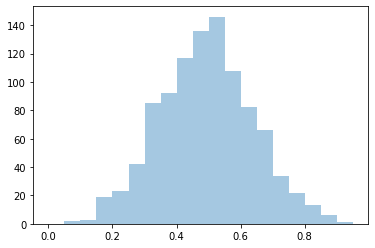

In [121]:
unimodal = np.random.normal(0.5,0.15,1000)
sns.distplot(unimodal,kde=False,bins=np.arange(0,1,0.05))
plt.show()
plt.close()